### Deriving pulsar properties from PWNe - testing
* Pair-production multiplicity via de Jager 2007 $<k> = \frac{N_e({\rm obs})}{2N_{GJ}}$
* Initial spin-down period $P_0$ via van de Swaluw 2001 & the ratio $R_{pwn}/R_{snr}$
* Relate $k$ to the fraction of hadronic particles present in the PWN (and hence hadronic emission component) 

In [1]:
import numpy as np
import astropy.units as u
from astropy import constants as c
import matplotlib.pyplot as plt
from psrqpy import QueryATNF
import matplotlib.pylab as pylab
from cycler import cycler
from itertools import cycle
from scipy.integrate import simps
from matplotlib.pyplot import cm
import matplotlib.ticker as ticker


params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large',
          'ytick.labelsize':'xx-large'}

pylab.rcParams.update(params)
plt.style.use('tableau-colorblind10')

%matplotlib inline

In [2]:
# Choose parameters from ATNF (or query the whole database)
query = QueryATNF() #params=['Edot','age',"dist","P0","P1","BINARY"])

In [3]:
# Convert them to PANDAS
table = query.table
table = table.to_pandas()

age_all = table["AGE"]
edot_all = table["EDOT"]
dist = table["DIST"]
period = table["P0"]
pdot = table["P1"]
#fatnf = 2*np.pi/np.asarray(period)/u.s

# Compute beam fraction correction
beam_fraction = 9 * np.power(np.log10((period)/10), 2) + 3
beam_fraction /= 100

# Selection to remove milli-second pulsars
sel = np.logical_and(np.invert(np.isnan(age_all)), np.invert(np.isnan(edot_all)))
sel = np.logical_and(sel, dist < 25) #within the Milky Way
sel = np.logical_and(sel, period > 0.01)
sel = np.logical_and(sel, pdot > 1e-18)
sel = np.logical_and(sel, age_all < 1e7)

#print(max(age))
#Now apply selection mask 
age_all = age_all[sel]

edot_all = edot_all[sel]
beam_fraction = beam_fraction[sel]
#dist = dist[sel]
#period = period[sel]
#pdot = pdot[sel]

### Pair-production mutiplicity
1) Use Halo paper results for known HESS PWNe to obtain $N_e$ via observations 
* i.e. use energy densities provided and properties of the assumed electron spectrum 
* Note: $E_{\rm min} = 100$GeV, $E_{\rm max}=1,3,10$TeV and $\Gamma = 2.2$

2) Use ATNF catalogue to obtain $N_{GJ}$ for the same pulsars via known properties
* see also eqn(2) of de Jager for the simplified version of $\dot{E}$


In [4]:
import pandas as pd

df = pd.read_csv("Pulsar_PWNe_properties - table_pulsars.csv")

In [5]:
df.columns

Index(['Name', 'ATNF J name', 'Edot [erg/s]', 'Size [pc]', 'Distance [kpc]',
       'Age [kyr]', 'Total_E [erg]', 'Volume [cm^3]', 'Edens [eV/cm^-3]',
       'mean_edens [eV/cm^-3]', 'min_edens [eV/cm^-3]', 'max_edens [eV/cm^-3]',
       'E_Threshold [TeV]', 'R_SNR [pc]', 'R_PWN [pc]', 'R_TeV [pc]',
       'R_Xray [pc]', 'LHAASO E_gmax (PeV)', 'LHAASO E_emax (PeV)',
       'Unnamed: 19', 'dN_e/dE', 'E_low [TeV]', 'E_0 [TeV]', 'E_max [TeV]',
       'N_e [cm^-3]', 'Notes', 'Unnamed: 26'],
      dtype='object')

In [6]:
#Obtain period and pdot from ATNF
atnf_names=df['ATNF J name']

period_atnf = np.zeros(len(df))
pdot_atnf = np.zeros(len(df))
print(table["NAME"][sel])
for i in range(len(df)):
    psr_idx = np.where(table["NAME"]==atnf_names[i])[0][0]
    period_atnf[i] = period[psr_idx]
    pdot_atnf[i] = pdot[psr_idx]


0       J0002+6216
1       J0006+1834
2       J0007+7303
45      J0040+5716
49      J0048+3412
           ...    
3335    J2325+6316
3342    J2330-2005
3345    J2337+6151
3355    J2354+6155
3358    J2355+2246
Name: NAME, Length: 1244, dtype: object


In [7]:
#Define properties of electron spectrum as per the halos paper
E0 = 1. *u.TeV
E2 = 10. *u.TeV #1, 3 or 10
#E1 = 0.1 *u.TeV
E1 = df['E_Threshold [TeV]']*u.TeV
Gam = 2.2

pow2 = 2-Gam
integral2 = ((E2)**pow2 - (E1)**pow2)/(pow2*E0**(1-Gam))

#Integration constant is total energy (from halos paper) divided by electron spectrum integral
print(df['E_Threshold [TeV]'])
k_intconst = df["Total_E [erg]"]*u.erg / integral2

0       NaN
1       NaN
2     0.387
3     0.388
4     0.610
5     0.894
6     0.759
7     0.501
8     0.395
9     0.470
10    0.388
11    0.759
12    0.784
13    0.396
14    0.683
15    0.694
16      NaN
17    0.170
18      NaN
19      NaN
20    0.532
21    0.742
22      NaN
23    0.492
24    0.442
25    0.442
26    0.428
27    0.587
28    0.757
29    0.757
30    0.383
31    0.383
32      NaN
33    0.389
34    0.744
35    0.388
36    0.388
37    0.492
38      NaN
39      NaN
40    0.379
41    0.379
42      NaN
43      NaN
44      NaN
45      NaN
46      NaN
47      NaN
Name: E_Threshold [TeV], dtype: float64


In [8]:
pow1 = 1-Gam
integral = ((E2/E0)**pow1 - (E1/E0)**pow1)/pow1

Nel = k_intconst*integral
#Number of electrons derived from observations
print(Nel[0])

nan


In [9]:
#for convenience
yr_to_s = (1. * u.yr).to(u.s)

In [10]:
#Edot and age as used in halos paper: 
edot = np.zeros(len(df))
age_halo = np.zeros(len(df))

for i in range(len(df)):
#     print(i)
    edot[i] = df["Edot [erg/s]"][i] 
    age_halo[i] = df["Age [kyr]"][i]
    

edot *= u.erg / u.s
age_halo *= u.kyr
# print(age_halo)

In [11]:
#Calculate age as a function of P0

def age_p0(psr_period,psr_pdot,p0=0.01*u.s,n=3):
    
    brk = n-1
    argp = p0/(psr_period*u.s)
    tau_age = 1. - argp**brk
    tau_age *= (psr_period*u.s)/(brk*psr_pdot)
    return tau_age.to(u.yr)

In [12]:
#Range of initial spin periods 
test_p0 = np.linspace(0.01,0.15,150)*u.s
print(test_p0)

[0.01       0.0109396  0.01187919 0.01281879 0.01375839 0.01469799
 0.01563758 0.01657718 0.01751678 0.01845638 0.01939597 0.02033557
 0.02127517 0.02221477 0.02315436 0.02409396 0.02503356 0.02597315
 0.02691275 0.02785235 0.02879195 0.02973154 0.03067114 0.03161074
 0.03255034 0.03348993 0.03442953 0.03536913 0.03630872 0.03724832
 0.03818792 0.03912752 0.04006711 0.04100671 0.04194631 0.04288591
 0.0438255  0.0447651  0.0457047  0.0466443  0.04758389 0.04852349
 0.04946309 0.05040268 0.05134228 0.05228188 0.05322148 0.05416107
 0.05510067 0.05604027 0.05697987 0.05791946 0.05885906 0.05979866
 0.06073826 0.06167785 0.06261745 0.06355705 0.06449664 0.06543624
 0.06637584 0.06731544 0.06825503 0.06919463 0.07013423 0.07107383
 0.07201342 0.07295302 0.07389262 0.07483221 0.07577181 0.07671141
 0.07765101 0.0785906  0.0795302  0.0804698  0.0814094  0.08234899
 0.08328859 0.08422819 0.08516779 0.08610738 0.08704698 0.08798658
 0.08892617 0.08986577 0.09080537 0.09174497 0.09268456 0.0936

In [13]:
#Calculate N_GJ integral, check current day values

def calc_ngj(edot_pwn,age_pwn,psr_age=10**3*u.yr,alpha=2):
    
    
    ys=np.arange(len(age_pwn),dtype='float64')
    for i in np.arange(len(ys)):
        t=np.linspace(0*u.s,age_pwn[i].to(u.s),100)
        edot_pwnt=edot_pwn*(1+t/psr_age)**alpha
        edot_pwnt=edot_pwnt.to(u.erg/u.s)
        integrand=1*(6*c.c.cgs*edot_pwnt)**0.5/c.e.gauss
        y=simps(integrand,t)
        ys[i]=y
    return ys
'''
#Plot edot (PWN,t), from Gunn and Ostriker, assumes theta=pi/4
def calc_ngj(age_pwn,patnf,Bp=10**12*u.cm**-0.5*u.g**0.5/u.s,a=(10*u.km).to(u.cm),theta=np.pi/4,I=1.4e45*u.g*u.cm**2):
    ys=np.arange(len(age_pwn),dtype='float64')
    fatnfc=2*np.pi/patnf/u.s
    print(patnf,fatnfc)
    for i in np.arange(len(ys)):
        t=np.linspace(0*u.s,age_pwn[i].to(u.s),100)
        tau0atnf=(6*I*c.c.cgs**3)/(Bp**2*a**6*np.sin(theta)**2*fatnfc**2)
        edot_pwn=(2/(3*c.c.cgs**3))*(Bp**2*(a**6)/4)*((np.sin(theta)**2*fatnfc**4)/(1+2*t/tau0atnf)**2)
        edot_pwn=edot_pwn.to(u.erg/u.s)
        integrand=1*(6*c.c.cgs*edot_pwn)**0.5/c.e.gauss
        y=simps(integrand,t)
        ys[i]=y
    return ys
'''

"\n#Plot edot (PWN,t), from Gunn and Ostriker, assumes theta=pi/4\ndef calc_ngj(age_pwn,patnf,Bp=10**12*u.cm**-0.5*u.g**0.5/u.s,a=(10*u.km).to(u.cm),theta=np.pi/4,I=1.4e45*u.g*u.cm**2):\n    ys=np.arange(len(age_pwn),dtype='float64')\n    fatnfc=2*np.pi/patnf/u.s\n    print(patnf,fatnfc)\n    for i in np.arange(len(ys)):\n        t=np.linspace(0*u.s,age_pwn[i].to(u.s),100)\n        tau0atnf=(6*I*c.c.cgs**3)/(Bp**2*a**6*np.sin(theta)**2*fatnfc**2)\n        edot_pwn=(2/(3*c.c.cgs**3))*(Bp**2*(a**6)/4)*((np.sin(theta)**2*fatnfc**4)/(1+2*t/tau0atnf)**2)\n        edot_pwn=edot_pwn.to(u.erg/u.s)\n        integrand=1*(6*c.c.cgs*edot_pwn)**0.5/c.e.gauss\n        y=simps(integrand,t)\n        ys[i]=y\n    return ys\n"

In [14]:
#Check Edot for J1513-5908
psr_idx = np.where(table["NAME"]=='J1513-5908')[0][0]
period_atnfi = period[psr_idx]
pdot_atnfi = pdot[psr_idx]
print(period_atnfi,pdot_atnfi)
Bp=10**12*u.cm**-0.5*u.g**0.5/u.s
a=(10*u.km).to(u.cm)
theta=np.pi/4
I=1.4e45*u.g*u.cm**2
age_pwni=age_p0(period_atnfi,pdot_atnfi)
Edotjager=I*(2*np.pi/period_atnfi/u.s)*(2*np.pi/pdot_atnfi/u.s**2)

fatnfc=2*np.pi/period_atnfi/u.s
t=np.linspace(0*u.s,age_pwni.to(u.s),100)
tau0atnf=(6*I*c.c.cgs**3)/(Bp**2*a**6*np.sin(theta)**2*fatnfc**2)
edot_pwn=(2/(3*c.c.cgs**3))*(Bp**2*(a**6)/4)*((np.sin(theta)**2*fatnfc**4)/(1+2*t/tau0atnf)**2)
edot_pwn=edot_pwn.to(u.erg/u.s)
print(Edotjager.to(u.erg/u.s),edot_pwn)

0.15158194339345915 1.5286897617091928e-12
2.385178822708124e+59 erg / s [9.13032498e+33 9.13025585e+33 9.13018674e+33 9.13011762e+33
 9.13004850e+33 9.12997938e+33 9.12991026e+33 9.12984115e+33
 9.12977203e+33 9.12970292e+33 9.12963381e+33 9.12956469e+33
 9.12949558e+33 9.12942647e+33 9.12935736e+33 9.12928825e+33
 9.12921914e+33 9.12915004e+33 9.12908093e+33 9.12901182e+33
 9.12894272e+33 9.12887361e+33 9.12880451e+33 9.12873541e+33
 9.12866630e+33 9.12859720e+33 9.12852810e+33 9.12845900e+33
 9.12838990e+33 9.12832080e+33 9.12825171e+33 9.12818261e+33
 9.12811351e+33 9.12804442e+33 9.12797532e+33 9.12790623e+33
 9.12783714e+33 9.12776805e+33 9.12769895e+33 9.12762986e+33
 9.12756077e+33 9.12749168e+33 9.12742260e+33 9.12735351e+33
 9.12728442e+33 9.12721534e+33 9.12714625e+33 9.12707717e+33
 9.12700808e+33 9.12693900e+33 9.12686992e+33 9.12680084e+33
 9.12673176e+33 9.12666268e+33 9.12659360e+33 9.12652452e+33
 9.12645544e+33 9.12638637e+33 9.12631729e+33 9.12624822e+33
 9.12617914e

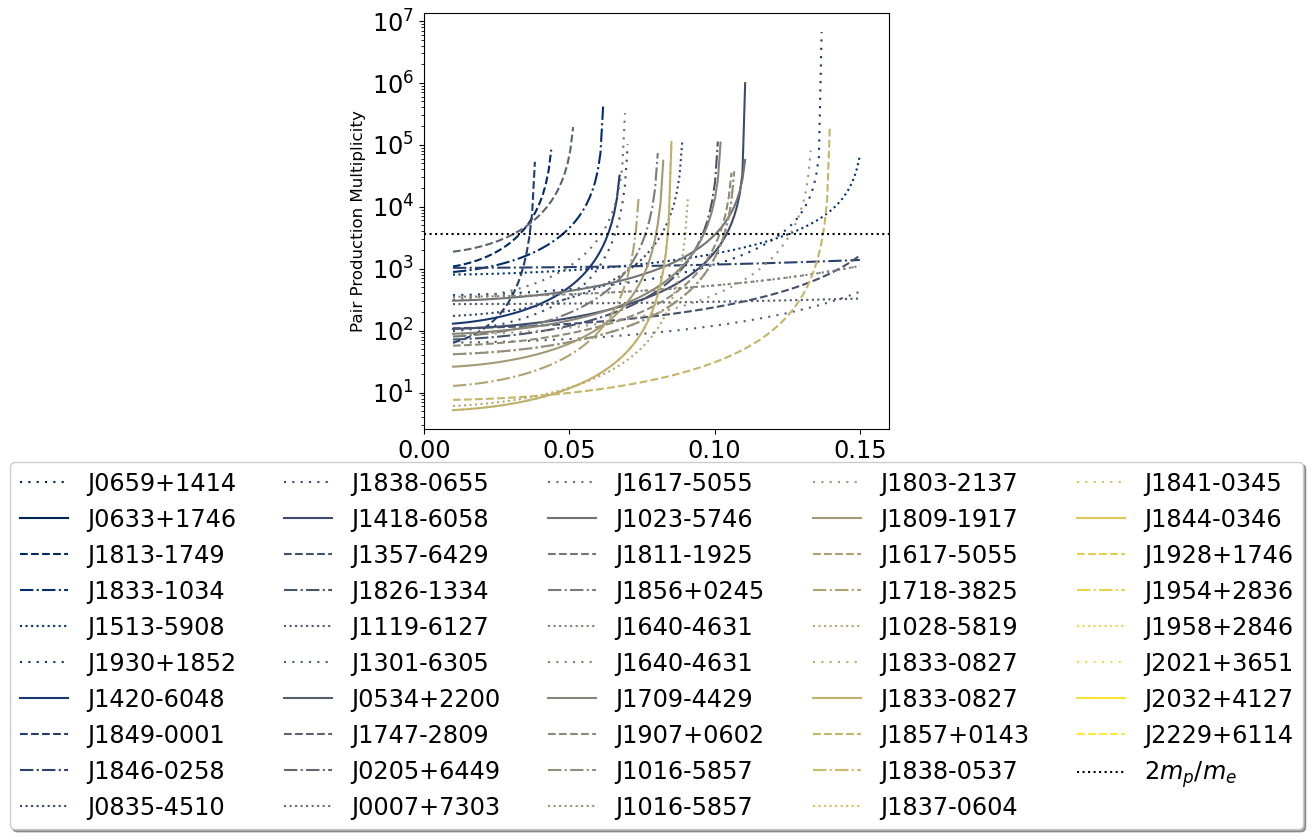

In [15]:
plt.figure(figsize=(6,6))
lines = [(0, (1, 3)),"-","--","-.",":"]
linecycler = cycle(lines)
#Now plot how the pair-production multiplicity varies with P0. 
color = cm.cividis(np.linspace(0, 1, len(df)))
#Only first 10 in df, as len(df) is a crowded plot
for i in range(len(df)):
    
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(edot[i],tau_p0)
    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    plt.plot(test_p0[mask],k_p0[mask],label=atnf_names[i],linestyle=next(linecycler),color=color[i])
    
plt.semilogy()
#plt.ylim(100.,1e6)
plt.xlim(0.0,0.16)
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':',label='$2m_p/m_e$')
plt.ylabel("Pair Production Multiplicity",fontsize=12)
plt.xlabel("Birth Period (s)",fontsize=12)
ax=plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

None

### Initial spin period
* Use eqn(6) of van der Swaluw - ratio of $R_{pwn}/R_{snr}$ can be obtained for e.g. table 1 of halo paper
 - doing this for the full table 2 will need a literature search
* Current spin period via ATNF catalogue
* Moment of inertia $I$ can be calculated, but $\eta_1$ and $\eta_3$ need to be assumed. 


Problem: $E_0$ - feels dangerous to assume this. 

Determine dependency of $P_0$ on assumed $E_0$? Or could assume a standard evolution of $\dot{E}$ towards present day values. 

In [16]:
#Expression for P0 from ratio based on van de Swaluw et al. 

def P0(R_pwn,R_snr,P_t,E0=1e51*u.erg,I=1.4e45*u.g*u.cm**2):
    eta_1 = 1.0
    eta_3 = 1.02
    R_ratio = R_pwn/(eta_3*R_snr)
    P_ratio = 2.*np.pi/P_t
    
    EI_term = 2.*E0 / (eta_1*I)
#     print(EI_term.to(1./u.s**2))
    
    P0 = (EI_term*R_ratio**3. + P_ratio**2)**-0.5
    P0 *= 2*np.pi
    
    return P0.to(u.s)

In [17]:
# atnf_names

In [18]:
#Reduced selection of PWNe (table 1 of halo paper)
bothradii = df['R_PWN [pc]'].notna()& df['R_SNR [pc]'].notna() #& table["F0"].notna() & table["F1"].notna()
print(len(df['Name'][bothradii].to_numpy()))
Names = df['Name'][bothradii].to_numpy()
Ratnf = df['ATNF J name'][bothradii].to_numpy()#add J1825, Geminga
Rsnr = df['R_SNR [pc]'][bothradii].to_numpy()*u.pc #Assume Crab SNR size = PWN size
Rpwn = df['R_PWN [pc]'][bothradii].to_numpy()*u.pc #making a guess for J1825
dists = df['Distance [kpc]'][bothradii].to_numpy()*u.kpc
print(Names)
print(dists)

6
['J1833-105' 'J1514-591' 'J1930+188' 'J1846-029' 'J0835-455' 'G0.9+0.1']
[ 4.1   4.4   7.    5.8   0.28 13.3 ] kpc


In [19]:
Patnf = np.zeros(len(Ratnf))
for i in range(len(Ratnf)):
    index = np.where(atnf_names==Ratnf[i])[0][0]
    Patnf[i] = period_atnf[index]

print(Patnf)

[0.06188365 0.15158194 0.13685505 0.32657129 0.08932839 0.05215285]


In [20]:
P_0 = P0(Rpwn,Rsnr,Patnf*u.s)

In [21]:
# print(P_0,Patnf)
#Ratio of P0 derived to current period in ATNF:
print(P_0 / (Patnf*u.s))

[0.53251237 0.10053579 0.30180072 0.1554733  0.12159543 0.91797585]


Now we have both $k$ as a function of $P_0$, for all pulsars/pwne considered in the halos paper, and constraints on $P_0$ for a subset of pwne for which we have more information (e.g. table 1 of the halos paper). 

Dashed lines below indicate the evaluated $P_0$ from the radius ratio. 
Where the lines of the same colour intersect, this gives the pair-production multiplicity for that PWN. 


J1833-1034 p0= 0.032953808907644225 Rsnr= 2.98 pc Rpwn= 0.8 pc p= 0.06188365001063282 pdot 2.020149962455173e-13 ,kappa= 1453.357354050249 nel= 4.5617898083450285e+48
J1513-5908 p0= 0.015239410525787624 Rsnr= 38.4 pc Rpwn= 19.2 pc p= 0.15158194339345915 pdot 1.5286897617091928e-12 ,kappa= 809.6894405952792 nel= 5.139356514523224e+47
J1930+1852 p0= 0.04130295131654276 Rsnr= 10.8 pc Rpwn= 2.7 pc p= 0.136855046957 pdot 7.5057e-13 ,kappa= 430.493710456857 nel= 5.05866694755819e+47
J1846-0258 p0= 0.0507731171134841 Rsnr= 2.6 pc Rpwn= 0.58 pc p= 0.3265712883437141 pdot 7.107449727350634e-12 ,kappa= 1060.5998722318304 nel= 1.6232676579837958e+47
J0835-4510 p0= 0.010861923156129938 Rsnr= 19.5 pc Rpwn= 12.2 pc p= 0.08932838502359318 pdot 1.2500779277088453e-13 ,kappa= 173.54049347840333 nel= 1.8657897360372003e+48
J1747-2809 p0= 0.04787506158892769 Rsnr= 19.8 pc Rpwn= 2.5 pc p= 0.052152855 pdot 1.5557e-13 ,kappa= 26620.984742318306 nel= 1.246558459695207e+49


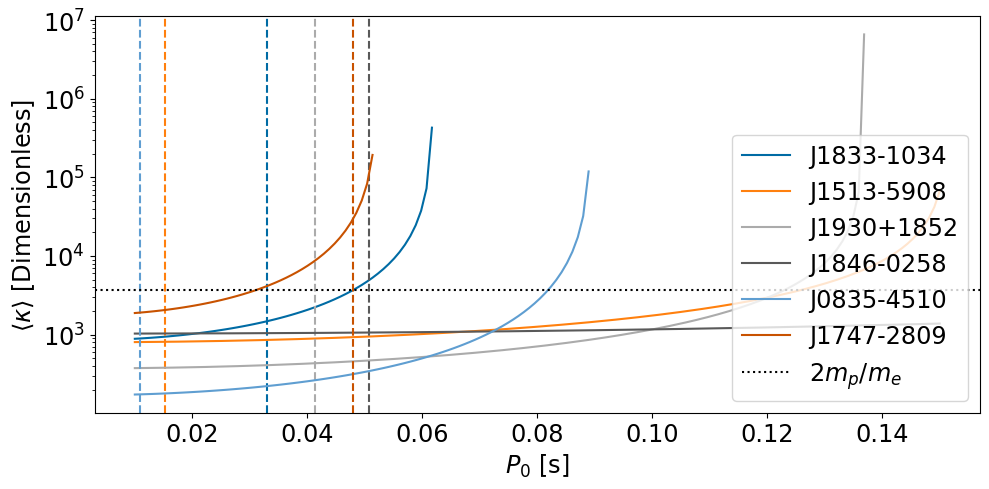

In [22]:
#Add these derived P0s to the plot above of k vs P0. 
fig=plt.figure(figsize=(10,5))
for index in range(len(Ratnf)):#len(df)):

    i = np.where(atnf_names==Ratnf[index])[0][0]
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(edot[i],tau_p0)

    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    print(Ratnf[index],'p0=',P_0[index].value,'Rsnr=',Rsnr[index],'Rpwn=',Rpwn[index],'p=',period_atnf[i],'pdot',pdot_atnf[i],',kappa=',k_p0[np.abs(P_0[index].value-test_p0[mask].value).argmin()],'nel=',Nel[i])
    #print(Ratnf[index],"p=",period_atnf[i],'pdot',pdot_atnf[i],'nel',Nel[i],'tau',tau_p0)
    #if Ratnf[index]=='J0835-4510':
    #    p = plt.plot(test_p0[mask],k_p0[mask],label='Vela Pulsar aka '+str(Ratnf[index]))
    #elif Ratnf[index]=='J1513-5908':
    #    p = plt.plot(test_p0[mask],k_p0[mask],label='B1509-58 aka '+str(Ratnf[index]))
    #else: 
    p = plt.plot(test_p0[mask],k_p0[mask],label=Ratnf[index])

    plt.axvline(P_0[index].value,linestyle='--',color=p[0].get_color())
    
plt.semilogy()
#plt.ylim(100.,1e6)
#plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':',label='$2m_p/m_e$')
plt.legend(ncols=1,loc=4)

plt.tight_layout()
plt.savefig('kappaplot.png',dpi=300)


0.06188365001063282 3.14e+13 101.53223518813148 1 / s [-3.28679361e+35 -3.28551792e+35 -3.28424297e+35 -3.28296876e+35
 -3.28169530e+35 -3.28042257e+35 -3.27915059e+35 -3.27787934e+35
 -3.27660884e+35 -3.27533907e+35 -3.27407004e+35 -3.27280175e+35
 -3.27153419e+35 -3.27026738e+35 -3.26900129e+35 -3.26773595e+35
 -3.26647133e+35 -3.26520745e+35 -3.26394431e+35 -3.26268189e+35
 -3.26142021e+35 -3.26015926e+35 -3.25889905e+35 -3.25763956e+35
 -3.25638080e+35 -3.25512277e+35 -3.25386547e+35 -3.25260890e+35
 -3.25135306e+35 -3.25009795e+35 -3.24884356e+35 -3.24758989e+35
 -3.24633696e+35 -3.24508474e+35 -3.24383325e+35 -3.24258249e+35
 -3.24133245e+35 -3.24008313e+35 -3.23883453e+35 -3.23758666e+35
 -3.23633951e+35 -3.23509307e+35 -3.23384736e+35 -3.23260237e+35
 -3.23135809e+35 -3.23011453e+35 -3.22887170e+35 -3.22762957e+35
 -3.22638817e+35 -3.22514748e+35] erg / s -3.365236437869983e+37 cm2 g / s3
0.15158194339345915 1.88e+14 41.45075044242182 1 / s [-9.13032498e+33 -9.13012947e+33 -9.1

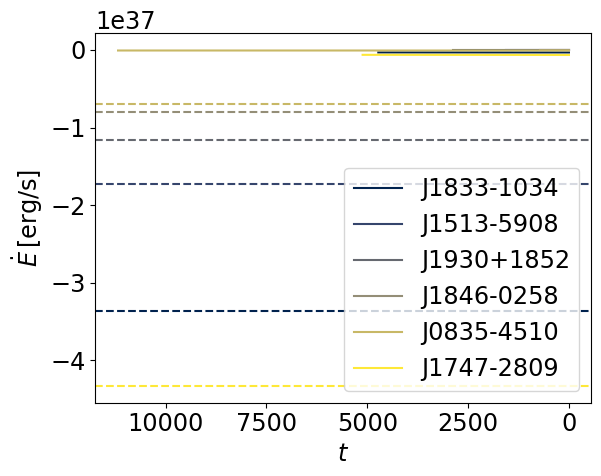

In [23]:
#Check EDot Calculations

Bp=10**12*u.cm**-0.5*u.g**0.5/u.s
a=(10*u.km).to(u.cm)
theta=np.pi/4
I=10**45*u.cm**2*u.g
color = cm.cividis(np.linspace(0, 1, len(Ratnf)))
j=0
for index in range(len(Ratnf)):
    i = np.where(atnf_names==Ratnf[index])[0][0]
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],10*u.ms)
    t=np.linspace(0*u.s,tau_p0)
    fatnf=2*np.pi/period_atnf[i]/u.s
    tau0atnf=(6*I*c.c.cgs**3)/(Bp**2*a**6*np.sin(theta)**2*fatnf**2)

    edot_pwn=-1*(2/(3*c.c.cgs**3))*(Bp**2*a**6/4)*((np.sin(theta)**2*fatnf**4)/(1+2*t/tau0atnf)**2)
    edot_pwn=edot_pwn.to(u.erg/u.s)
    plt.plot(t,edot_pwn.value,label=Ratnf[index],color=color[j])
    dotE=-4*np.pi**2*I*pdot_atnf[i]/period_atnf[i]**3/u.s**3
    print(period_atnf[i],'%.2e'%tau0atnf.value,fatnf,edot_pwn,dotE)
    plt.axhline(dotE.value,color=color[j],linestyle='dashed')
    j+=1
ax=plt.gca()
ax.invert_xaxis()

plt.xlabel(r"$t$")
plt.ylabel("$\dot{E}\,\mathrm{[erg/s]}$")
plt.legend(ncols=1,loc=4)

J1833-1034 p= 0.06188365001063282 P0= 0.032953808907644225 s 56 kappa= 1453.357354050249
J1833-1034 0.032953808907644225 s 0.032953808907644225 s 0.032953808907644225 s
J1513-5908 p= 0.15158194339345915 P0= 0.015239410525787624 s 150 kappa= 809.6894405952792
J1513-5908 0.015239410525787624 s 0.015239410525787624 s 0.03827537618747317 s
J1930+1852 p= 0.136855046957 P0= 0.04130295131654276 s 136 kappa= 430.493710456857
J1930+1852 0.04130295131654276 s 0.04130295131654276 s 0.04130295131654276 s
J1846-0258 p= 0.3265712883437141 P0= 0.0507731171134841 s 150 kappa= 1060.5998722318304
J1846-0258 0.0507731171134841 s 0.0507731171134841 s 0.0507731171134841 s
J0835-4510 p= 0.08932838502359318 P0= 0.010861923156129938 s 85 kappa= 173.54049347840333
J0835-4510 0.010861923156129938 s 0.010861923156129938 s 0.062054804358874636 s
J1747-2809 p= 0.052152855 P0= 0.04787506158892769 s 45 kappa= 26620.984742318306
J1747-2809 0.04787506158892769 s 0.04787506158892769 s 0.03362466490440795 s


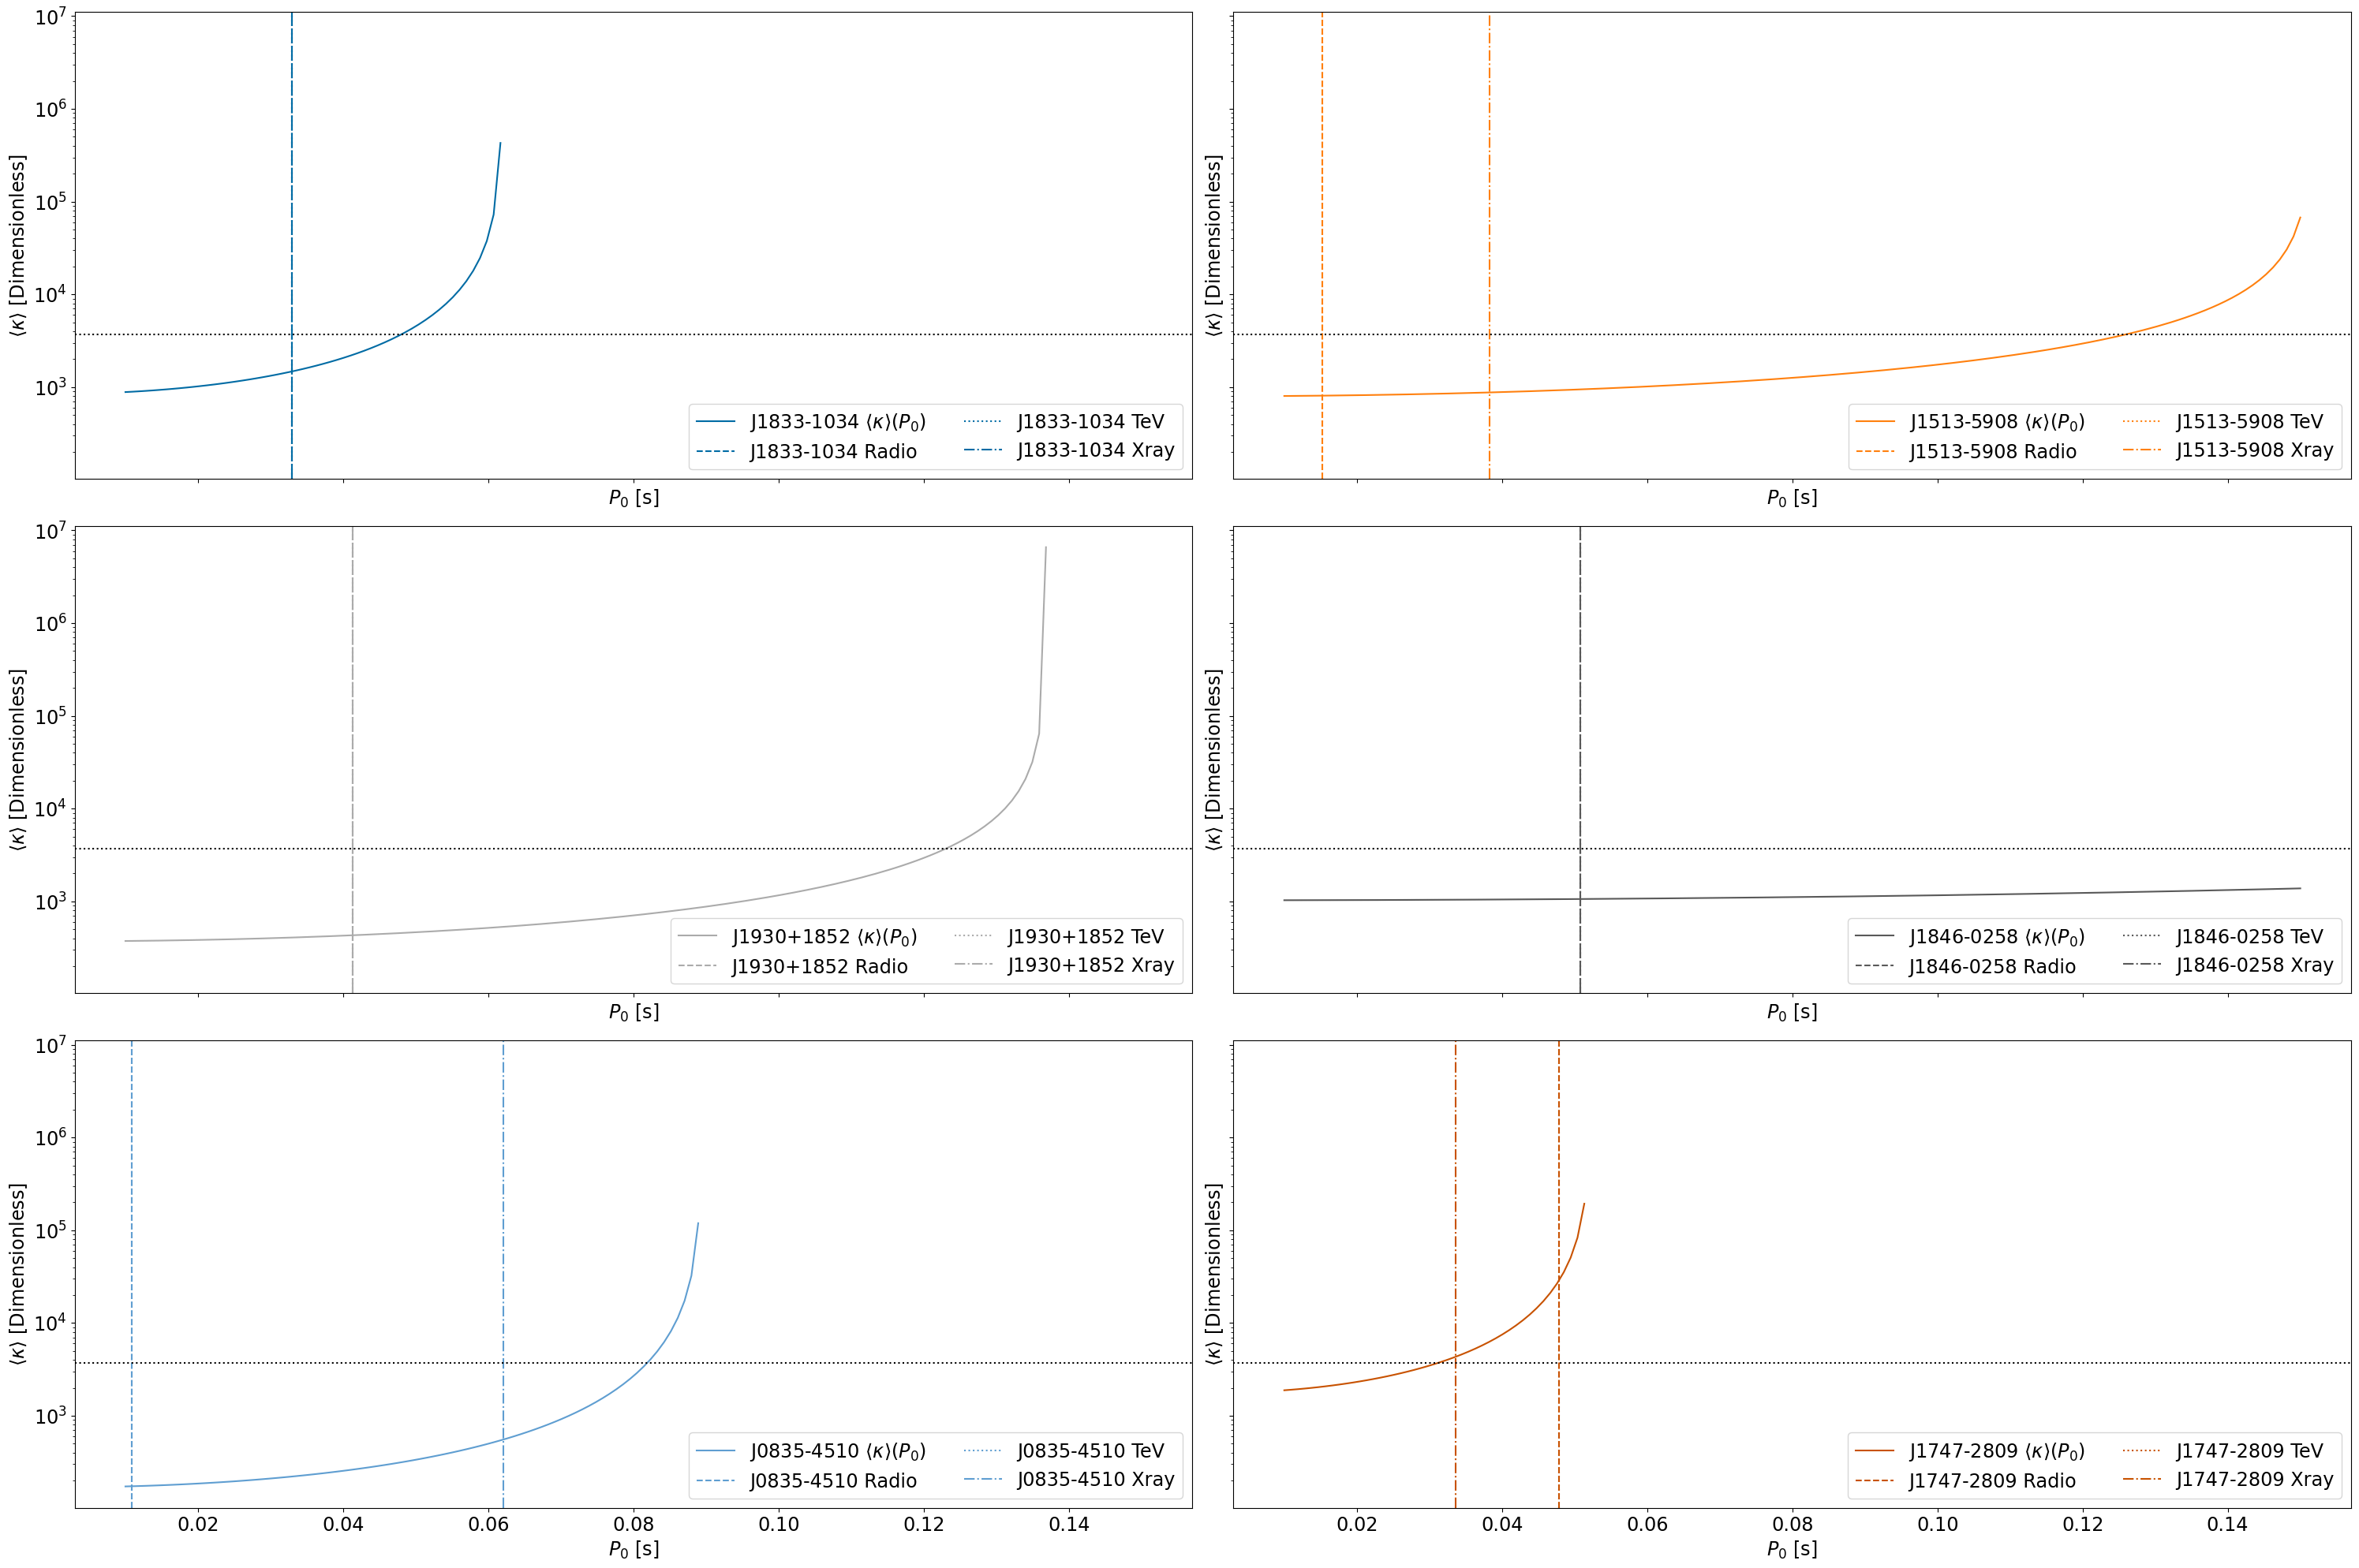

In [24]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = cycle(prop_cycle.by_key()['color'])


R_TeV=df['R_PWN [pc]'][bothradii].to_numpy()*u.pc
R_Xray=df['R_Xray [pc]'][bothradii].to_numpy()*u.pc

P_0 = P0(Rpwn,Rsnr,Patnf*u.s)
P_TeV = P0(R_TeV,Rsnr,Patnf*u.s)
P_Xray = P0(R_Xray,Rsnr,Patnf*u.s)
fig,axs=plt.subplots(3,2,sharex=True,sharey=True,figsize=(30,20))
axs=axs.reshape(-1)
for index in range(len(Ratnf)):#len(df)):
    mycol=next(colors)
    i = np.where(atnf_names==Ratnf[index])[0][0]
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(edot[i],tau_p0)

    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    print(Ratnf[index],"p=",period_atnf[i],"P0=",P_0[index],sum(mask),'kappa=',k_p0[np.abs(P_0[index].value-test_p0[mask].value).argmin()])
    
    p = axs[index].plot(test_p0[mask],k_p0[mask],color=mycol, label=Ratnf[index]+r' $\langle \kappa \rangle (P_0)$')
    axs[index].axvline(P_0[index].value,linestyle='--',label=Ratnf[index]+' Radio',color=mycol)
    axs[index].axvline(P_TeV[index].value,linestyle=':',label=Ratnf[index]+' TeV',color=mycol)
    axs[index].axvline(P_Xray[index].value,linestyle='-.',label=Ratnf[index]+' Xray',color=mycol)
    print(Ratnf[index],P_0[index],P_TeV[index],P_Xray[index])
    
    axs[index].semilogy()
    #axs[index].set_ylim(100.,1e6)
    #axs[index].set_xlim(0.0,0.16)
    axs[index].set_ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
    axs[index].set_xlabel("$P_0\ \mathrm{[s]}$")
    axs[index].legend(ncols=2,loc=4)
    axs[index].axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
plt.tight_layout()
plt.savefig('rplot.png',dpi=300)

In [25]:
2*c.m_p/c.m_e

<Quantity 3672.30534688>

The desired pair-production multiplicity for hadrons from the pulsar surface to reach the PWN is that 
$k \lesssim 2m_p/m_e = 3672 $ which is given by the horizontal dotted line. 

We can therefore exclude the PWNe studied here as being systems in which that could have happened, with the possible exception of Vela and J1825-137. 

1.9692251953896415e+49
5.157494559353824e+47
5.157494559353822e+47
5.157494559353823e+47
5.157494559353823e+47


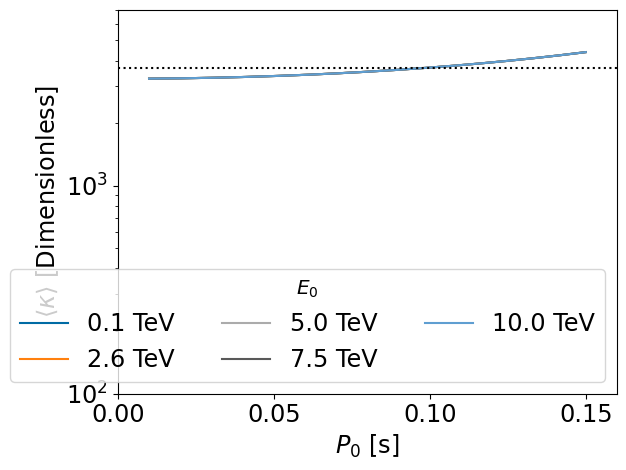

In [26]:
E0range=np.linspace(0.1,10,5)*u.TeV
E2 = 10. *u.TeV #1, 3 or 10
E1 = 0.1 *u.TeV
Gam = 2.2
pow2 = 2-Gam
pow1 = 1-Gam


for index in range(len(E0range)):#len(df)):
    E0 = E0range[index]
    integral2 = ((E2)**pow2 - (E1)**pow2)/(pow2*E0**(1-Gam))
    integral = ((E2/E0)**pow1 - (E1/E0)**pow1)/pow1
    k_intconst = df["Total_E [erg]"]*u.erg / integral2
    Nel = k_intconst*integral
    print(Nel[i])
    i = np.where(atnf_names=='J1846-0258')[0][0]
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(edot[i],tau_p0)

    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    p = plt.plot(test_p0[mask],k_p0[mask],label='%.1f'%E0range[index].value+' TeV')
    
plt.semilogy()
plt.ylim(0.1e3,7e3)
plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.legend(title='$E_0$',ncols=3,loc=4,title_fontsize='x-large')
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')

plt.tight_layout()
plt.savefig('e0scan.png',dpi=300)

2.1998138454322488e+47
5.157494559353822e+47
8.523114408763807e+47


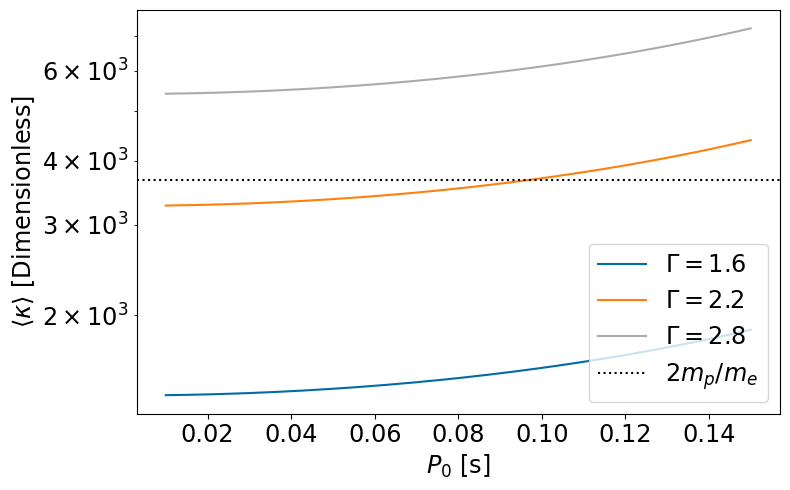

In [27]:
E2=10*u.TeV
E0 = 1 *u.TeV #1, 3 or 10
E1 = 0.1 *u.TeV
Gamrange = np.asarray([1.6,2.2,2.8]) #try 1.6-2.6

fig=plt.figure(figsize=(8,5))

for index in range(len(Gamrange)):#len(df)):
    Gam = Gamrange[index]
    pow2 = 2-Gam
    pow1 = 1-Gam
    integral2 = ((E2)**pow2 - (E1)**pow2)/(pow2*E0**(1-Gam))
    integral = ((E2/E0)**pow1 - (E1/E0)**pow1)/pow1
    k_intconst = df["Total_E [erg]"]*u.erg / integral2
    Nel = k_intconst*integral
    print(Nel[i])
    i = np.where(atnf_names=='J1846-0258')[0][0]
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(edot[i],tau_p0)

    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    p = plt.plot(test_p0[mask],k_p0[mask],label='$\Gamma=$'+'%.1f'%Gamrange[index])
    
plt.semilogy()
#plt.xlim(0,0.15)
#plt.ylim(1e3,7e3)

#plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':',label='$2m_p/m_e$')
x=plt.gca()
y_labels = ax.get_yticks()
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e'))
plt.legend(ncols=1,loc=4,title_fontsize='xx-large')
plt.tight_layout()
plt.savefig('gamscan.png',dpi=300)

7.912414054659201e+47
6.208755008159554e+47
5.157494559353822e+47


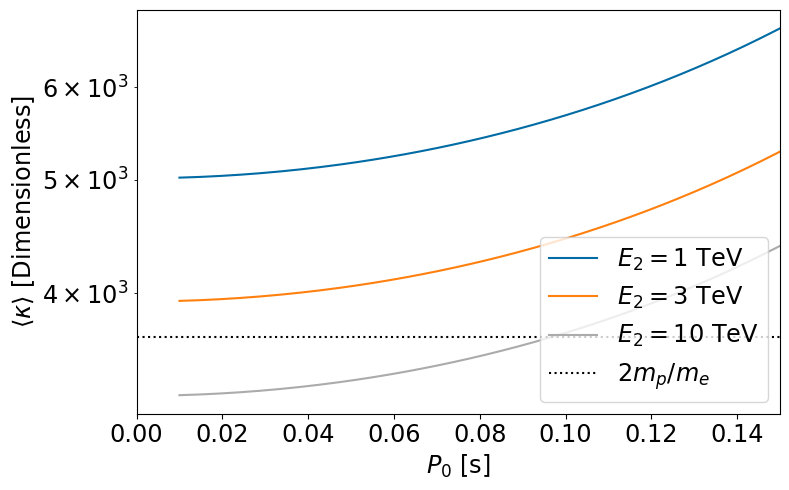

In [65]:
E2range=np.asarray([1,3,10])*u.TeV
E0 = 1 *u.TeV #1, 3 or 10
E1 = 0.1 *u.TeV
Gam = 2.2
pow2 = 2-Gam
pow1 = 1-Gam

fig=plt.figure(figsize=(8,5))

for index in range(len(E2range)):#len(df)):
    E2 = E2range[index]
    integral2 = ((E2)**pow2 - (E1)**pow2)/(pow2*E0**(1-Gam))
    integral = ((E2/E0)**pow1 - (E1/E0)**pow1)/pow1
    k_intconst = df["Total_E [erg]"]*u.erg / integral2
    Nel = k_intconst*integral
    print(Nel[i])
    i = np.where(atnf_names=='J1846-0258')[0][0]
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(edot[i],tau_p0)

    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    p = plt.plot(test_p0[mask],k_p0[mask],label='$E_2=$'+'%.0f'%E2range[index].value+' TeV')
    
plt.semilogy()
#plt.ylim(1e3,7e3)
#plt.xlim(0.0,0.16)
ax=plt.gca()
y_labels = ax.get_yticks()
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':',label='$2m_p/m_e$')
plt.legend(ncols=1,loc=4,title_fontsize='xx-large')
plt.xlim(0,0.15)
ax=plt.gca()


plt.tight_layout()
plt.savefig('e2scan.png',dpi=300)

<Figure size 800x500 with 0 Axes>

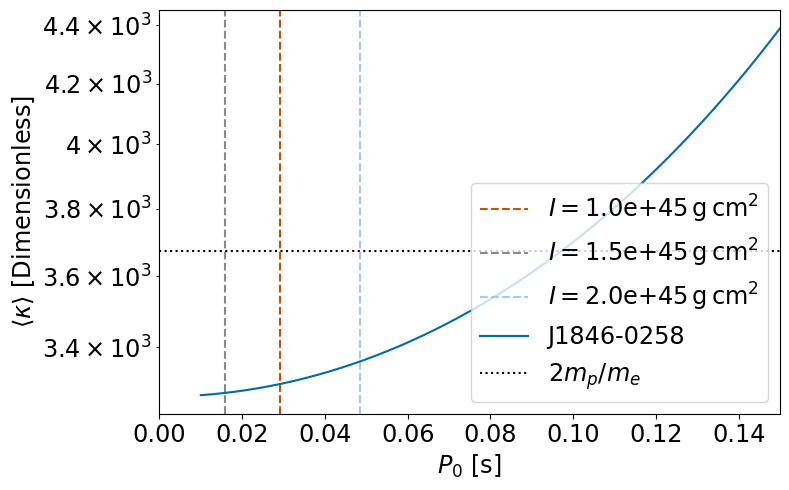

<Figure size 640x480 with 0 Axes>

In [79]:
E2=10*u.TeV
E0 = 1 *u.TeV #1, 3 or 10
E1 = 0.1 *u.TeV
Gam = 2.2
pow2 = 2-Gam
pow1 = 1-Gam
fig=plt.figure(figsize=(8,5))

Irange=np.linspace(1e45,2e45,3)*u.g*u.cm**2
fig=plt.figure(figsize=(8,5))
for index in range(len(Irange)):#len(df)):
    P_0dup = P0(Rpwn,Rsnr,Patnf*u.s,I=Irange[index])

    integral2 = ((E2)**pow2 - (E1)**pow2)/(pow2*E0**(1-Gam))
    integral = ((E2/E0)**pow1 - (E1/E0)**pow1)/pow1
    k_intconst = df["Total_E [erg]"]*u.erg / integral2
    Nel = k_intconst*integral
    i = np.where(atnf_names=='J1846-0258')[0][0]
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(edot[i],tau_p0)

    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    plt.axvline(P_0dup[index].value,linestyle='--',label='$I=$'+'%.1e'%Irange[index].value+'$\mathrm{\,g\,cm^2}$',color=next(colors))


    

p = plt.plot(test_p0[mask],k_p0[mask],label='J1846-0258')
ax=plt.gca()
y_labels = ax.get_yticks()
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
plt.semilogy()
#plt.ylim(100.,1e6)
plt.xlim(0,0.15)
#plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':',label='$2m_p/m_e$')
plt.legend(ncols=1,loc=4,title_fontsize='xx-large')
plt.tight_layout()
plt.show()
plt.savefig('I.png',dpi=300)

Total energy 0.45408929806259407
9.57209194262778e-14
6.360568077380392e+46


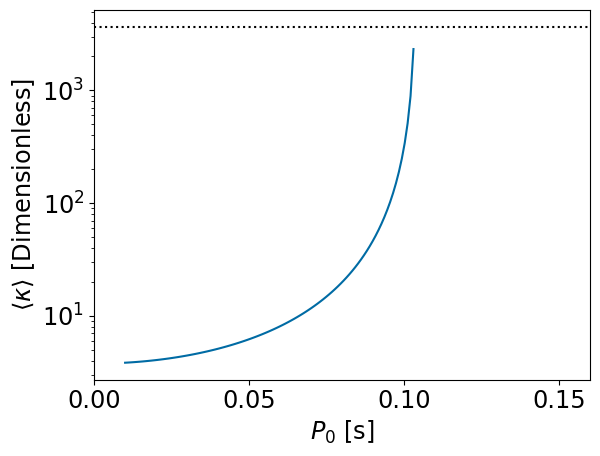

In [30]:
#Dragonfly, J2018+3651 from https://arxiv.org/pdf/1907.12121.pdf
#Approach, numerically integrate power law with exponential cutoff.

x=np.linspace(25,1.4e3,100)*u.TeV #Lower bound is 1 MeV. Use Cao et al threshold of 25TeV?  Maximum particle energy from https://ui.adsabs.harvard.edu/abs/2023ApJ...954....9W/abstract of 1.4PeV
E0=1*u.TeV #Pivot energy is 1 TeV
Ecut=0.9*u.PeV #Cutoff is 900 TeV
completeenergy=(x/E0)**-1.4*np.exp(-x/Ecut)#alpha is 2.4
print("Total energy",simps(completeenergy,x))
#kconst=6.1e49*u.erg/simps(completeenergy,x) #Calculate electron spectrum normalisation
kconst=3.9e48*u.erg/simps(completeenergy,x) #Dynamical model
y=kconst*(x/E0)**-2.4*np.exp(-x/Ecut) #Electron Spectrum
nel=simps(kconst*(x/E0)**-2.4*np.exp(-x/Ecut),x) #Integrate dN/dE
i=np.where(atnf_names=='J2021+3651')[0][0] #Locate pulsar and calculate ngj
print(pdot_atnf[i])
tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
ngj_p0 = calc_ngj(edot[i],tau_p0)
print(nel)
k_p0 = nel / (2.*ngj_p0)
mask = test_p0 < period_atnf[i]*u.s
plt.plot(test_p0[mask],k_p0[mask],label=atnf_names[i])
plt.semilogy()
#plt.ylim(100.,1e8)
plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':',label='$2m_p/m_e$')
np.savetxt('J2018x.txt',test_p0[mask].value)
np.savetxt('J2018y.txt',k_p0[mask])

1.547030973036675e-13
8.542722514065713e+44 [ 4.40959568e+45  4.39689274e+45  4.38307052e+45  4.36813436e+45
  4.35209005e+45  4.33494381e+45  4.31670229e+45  4.29737260e+45
  4.27696228e+45  4.25547930e+45  4.23293210e+45  4.20932952e+45
  4.18468087e+45  4.15899589e+45  4.13228477e+45  4.10455811e+45
  4.07582698e+45  4.04610287e+45  4.01539774e+45  3.98372395e+45
  3.95109433e+45  3.91752213e+45  3.88302106e+45  3.84760525e+45
  3.81128928e+45  3.77408817e+45  3.73601738e+45  3.69709280e+45
  3.65733078e+45  3.61674810e+45  3.57536196e+45  3.53319003e+45
  3.49025041e+45  3.44656163e+45  3.40214267e+45  3.35701295e+45
  3.31119233e+45  3.26470109e+45  3.21755999e+45  3.16979019e+45
  3.12141331e+45  3.07245142e+45  3.02292699e+45  2.97286298e+45
  2.92228276e+45  2.87121014e+45  2.81966937e+45  2.76768517e+45
  2.71528265e+45  2.66248740e+45  2.60932543e+45  2.55582320e+45
  2.50200760e+45  2.44790596e+45  2.39354607e+45  2.33895613e+45
  2.28416480e+45  2.22920118e+45  2.17409480e+

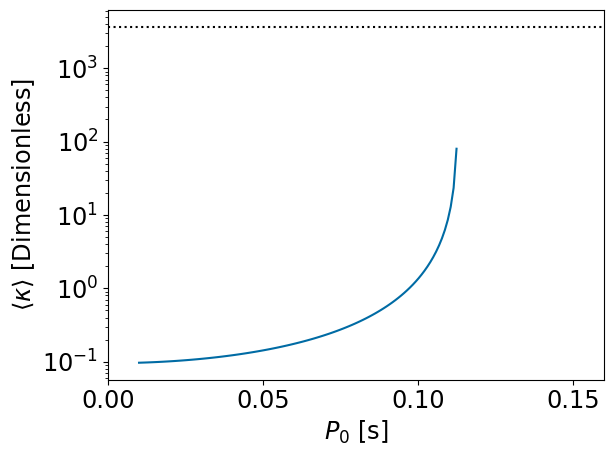

In [31]:
#J1843-0338
x=np.linspace(1e-5,740,100)*u.TeV #-5 #Assumed max energy from https://iopscience.iop.org/article/10.3847/1538-4357/ace967/pdf
#x=np.linspace(17.8,200,100)*u.TeV #Use HAWC energy threshold of 56 TeV
E0=7*u.TeV
Ecut=72*u.TeV

kconst=7.1*10**31/u.eV
nel=simps(kconst*(x/E0)**-2.17*np.exp(-x/Ecut),x) #Directly integrate spectrum
i=np.where(atnf_names=='J1844-0346')[0][0]
print(pdot_atnf[i])
tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
ngj_p0 = calc_ngj(edot[i],tau_p0)
print(nel,ngj_p0)
k_p0 = nel / (2.*ngj_p0)
mask = test_p0 < period_atnf[i]*u.s
plt.plot(test_p0[mask],k_p0[mask],label=atnf_names[i])
plt.semilogy()
#plt.ylim(100.,1e8)
plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
np.savetxt('J1843x.txt',test_p0[mask].value)
np.savetxt('J1843y.txt',k_p0[mask])

1.415651e-14
7.323263000526227e+43 erg [ 7.39115356e+46  7.18740993e+46  6.96862205e+46  6.73562488e+46
  6.48932212e+46  6.23068626e+46  5.96075854e+46  5.68064896e+46
  5.39153629e+46  5.09466804e+46  4.79136051e+46  4.48299874e+46
  4.17103653e+46  3.85699646e+46  3.54246986e+46  3.22911681e+46
  2.91866617e+46  2.61291556e+46  2.31373134e+46  2.02304865e+46
  1.74287140e+46  1.47527223e+46  1.22239257e+46  9.86442597e+45
  7.69701253e+45  5.74516241e+45  4.03304024e+45  2.58549828e+45
  1.42807639e+45  5.87002041e+44  8.91903222e+43 -4.93426318e+43
 -3.21555516e+44 -1.02187479e+45 -2.18009801e+45 -3.82642959e+45
 -5.99194895e+45 -8.70835179e+45 -1.20082728e+46 -1.59232945e+46
 -2.04910786e+46 -2.57419894e+46 -3.17133741e+46 -3.84387528e+46
 -4.59556873e+46 -5.43064610e+46 -6.35239156e+46 -7.36466137e+46
 -8.47138044e+46 -9.67654240e+46 -1.09844174e+47 -1.23991374e+47
 -1.39247480e+47 -1.55655196e+47 -1.73257918e+47 -1.92099728e+47
 -2.12225393e+47 -2.33680369e+47 -2.56510800e+47 -2

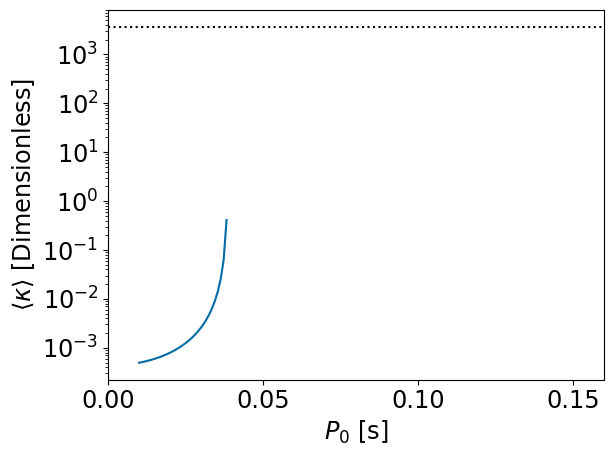

In [32]:
#J1849-000 https://iopscience.iop.org/article/10.3847/1538-4357/acebce/pdf, now using total energy
#rather than kconst

E0=10*u.TeV
#E1=0.1*u.TeV From paper in final column
E1=0.501*u.TeV #From H.E.S.S. GPS
E2=100*u.TeV
kconst=10**31.98/u.eV
gam1=-2.46
toten=2.8*10**47*u.erg
x=np.linspace(0.1,0.74e3,100)*u.TeV #Use 95% cutoff limit from https://iopscience.iop.org/article/10.3847/1538-4357/acebce

y=(x/E0).to(u.eV/u.eV)**(gam1)

kconst=toten/simps(y,x)

nel=kconst*((E2/E0).to(u.eV/u.eV)**(gam1+1)/(gam1+1)-(E1/E0).to(u.eV/u.eV)**(gam1+1))/(gam1+1)
i=np.where(atnf_names=='J1849-0001')[0][0]
print(pdot_atnf[i])

tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
ngj_p0 = calc_ngj(edot[i],tau_p0)
print(nel,ngj_p0)

k_p0 = nel / (2.*ngj_p0)
mask = test_p0 < period_atnf[i]*u.s
plt.plot(test_p0[mask],k_p0[mask],label=atnf_names[i])
plt.semilogy()
#plt.ylim(100.,1e8)
plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
np.savetxt('J1849x.txt',test_p0[mask].value)
np.savetxt('J1849y.txt',k_p0[mask].value)

7.525173771677164e-14


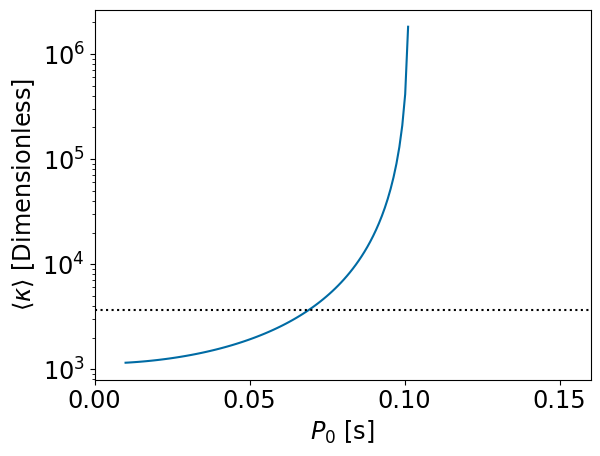

In [33]:
#J1825-137

#e1=1*u.TeV 
e1=0.396*u.TeV #HESS GPS
ebreak=0.9*u.TeV
gam1=-1.4
gam2=-3.25
Etot=5.5e48*u.erg
x1=np.linspace(0.7,ebreak.value,100)*u.TeV
x2=np.linspace(ebreak.value,42,100)*u.TeV #Limit from https://www.nature.com/articles/s41586-021-03498-z/tables/1
y1=x1**(gam1+1)/gam1
y2=x2**(gam2+1)/gam2
z1=x1**gam1
z2=x2**gam2

kprop=Etot/(simps(y2,x2)+simps(y1,x1)) #Determine proportionality constant for broken power law
nel=kprop*(simps(x2,z2)+simps(x1,z1)) #Calculate electron number for broken power law

i=np.where(atnf_names=='J1826-1334')[0][0]
print(pdot_atnf[i])

tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
ngj_p0 = calc_ngj(edot[i],tau_p0)
k_p0 = nel / (2.*ngj_p0)
mask = test_p0 < period_atnf[i]*u.s
plt.plot(test_p0[mask],k_p0[mask],label=atnf_names[i])
plt.semilogy()
#plt.ylim(100.,1e8)
plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
np.savetxt('J1825x.txt',test_p0[mask].value)
np.savetxt('J1825y.txt',k_p0[mask].value)

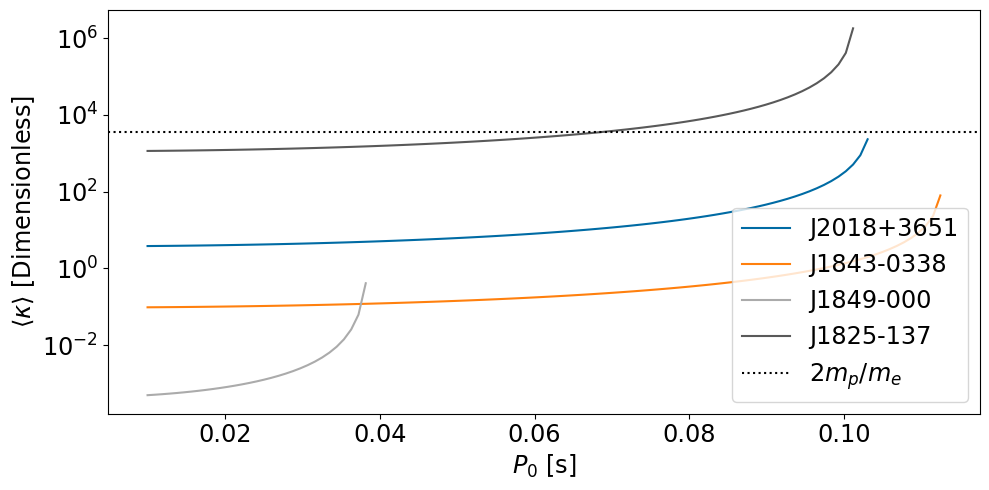

In [34]:
#LHAASO Sources Plot

fig=plt.figure(figsize=(10,5))

x2018=np.genfromtxt('J2018x.txt')
y2018=np.genfromtxt('J2018y.txt')
plt.plot(x2018,y2018,label='J2018+3651')
x1843=np.genfromtxt('J1843x.txt')
y1843=np.genfromtxt('J1843y.txt')
plt.plot(x1843,y1843,label='J1843-0338')
x1849=np.genfromtxt('J1849x.txt')
y1849=np.genfromtxt('J1849y.txt')
plt.plot(x1849,y1849,label='J1849-000')
x1825=np.genfromtxt('J1825x.txt')
y1825=np.genfromtxt('J1825y.txt')
plt.plot(x1825,y1825,label='J1825-137')
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.semilogy()
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':',label='$2m_p/m_e$')
plt.legend(loc=4)
plt.tight_layout()
plt.savefig('lhassoplot.png',dpi=300)

PearsonRResult(statistic=0.7690187537058234, pvalue=0.07386680966229994)
The a is  3.108724468950439e-16
The b is  0.5190490821894531
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 798
    # data points      = 6
    # variables        = 2
    chi-square         = 4.0606e+08
    reduced chi-square = 1.0151e+08
    Akaike info crit   = 112.181460
    Bayesian info crit = 111.764979
##  Warning: uncertainties could not be estimated:
    a:  at initial value
    a:  at boundary
[[Variables]]
    a:  3.1087e-16 (init = 1e-20)
    b:  0.51904908 (init = 0)
[  138.11823694   144.95149739   152.1228265    159.64894989
   167.54742064   175.83666027   184.53600166   193.6657342
   203.24715104   213.30259882   223.85552973   234.93055625
   246.55350854   258.75149466   271.55296385   284.98777281
   299.08725539   313.88429566   329.41340456   345.71080046
   362.81449358   380.76437466   399.60230801   419.37222911
   440.12024711   461.89475237   484.7465293

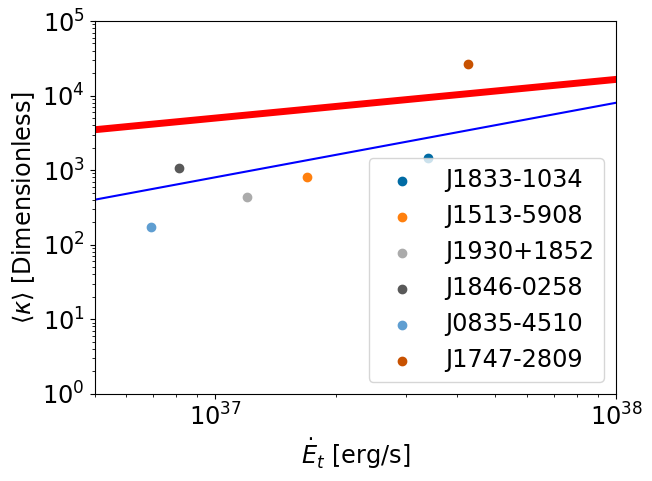

In [35]:
from lmfit import Parameters,minimize, fit_report
from scipy.stats import pearsonr

def power_fitting_lmfit(params,x,y):
    a = params['a']
    b = params['b']
    y_fit = a* x **b
    return y_fit-y

psrs=['J1833-1034','J1513-5908','J1930+1852','J1846-0258','J0835-4510','J1747-2809']
kappas=[1453.357354050249,809.6894405952792,430.493710456857,1060.5998722318304,173.54049347840333,26620.984742318306]
edots=np.asarray([3.38844156139203e37,1.69824365246173e37,1.2022644346174e37,8.12830516164092e36,6.91830970918941e36,4.26579518801595e37])

for i in np.arange(len(psrs)):
    plt.scatter(edots[i],kappas[i],linestyle='None',label=psrs[i])

print(pearsonr(edots,kappas))
    
params = Parameters()
# Slope is bounded between min value of 1.0 and max value of 3.0
params.add('a',min=1e-20,max=2e-1)
# Intercept is made fixed at 0.0 value
params.add('b',min=0,max=2)

# Calling the minimize function. Args contains the x and y data.
fitted_params = minimize(power_fitting_lmfit, params, args=(edots,kappas,), method='least-squares',max_nfev=1000000000,nan_policy='omit')
a = fitted_params.params['a'].value
b = fitted_params.params['b'].value    

# Printing the fitted values
print('The a is ', a)
print('The b is ', b)

print(fit_report(fitted_params))

px=np.logspace(34,38,100)
plt.plot(px, a*(px)**b,c='red',ls='-',lw=5)
plt.plot(px,0.8e-34*px**1,c='blue')
#plt.loglog(px, np.exp(result.eval(x=px)),  color="k")
print(a*(px)**b)
plt.xlabel(r'$\dot{E}_t$ [erg/s]')
plt.ylabel(r'$\langle\kappa\rangle$ [Dimensionless]')
plt.legend()
plt.loglog()
plt.tight_layout()
plt.xlim(5e36,1e38)
plt.ylim(1,1e5)
plt.savefig('et.png',dpi=300)

0.06188365001063282 2.02014996e-13 0.032953808907644225 s
0.15158194339345915 1.5286897617091928e-12 0.015239410525787624 s
0.136855046957 7.5057e-13 0.04130295131654276 s
0.3265712883437141 7.107449727350634e-12 0.0507731171134841 s
0.0893283850235931 1.2500779277088453e-13 0.010861923156129938 s
0.052152855 1.5557e-13 0.04787506158892769 s
PearsonRResult(statistic=-0.26997534088225345, pvalue=0.604875792448356)


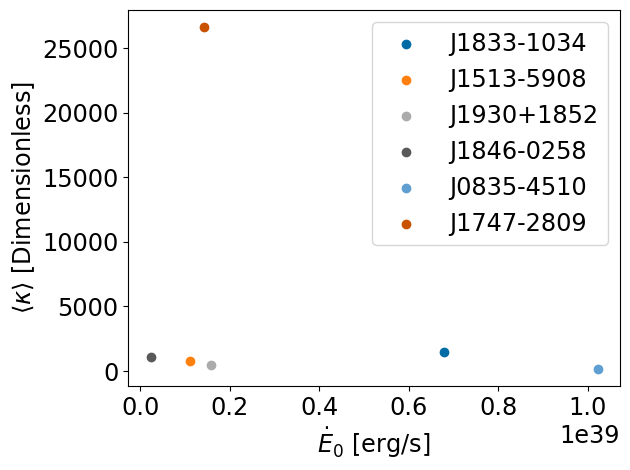

In [36]:
pnows=[0.06188365001063282,0.15158194339345915,0.136855046957,0.3265712883437141,0.0893283850235931,0.052152855]
pdots=[2.02014996E-13,1.5286897617091928e-12,7.5057e-13,7.107449727350634e-12,1.2500779277088453e-13,1.5557e-13]*u.s/u.s
p0s=[0.032953808907644225,0.015239410525787624,0.04130295131654276,0.0507731171134841,0.010861923156129938,0.04787506158892769]*u.s
edot0s=[]
for i in np.arange(len(psrs)):
    print(pnows[i],pdots[i],p0s[i])
    age=age_p0(pnows[i],pdots[i],p0s[i])
    edot0=edots[i]*u.erg/u.s*(1+age/(10**3*u.yr))**2
    plt.scatter(edot0,kappas[i],linestyle='None',label=psrs[i])
    edot0s.append(edot0.value)

print(pearsonr(np.asarray(edot0s),kappas))

plt.xlabel(r'$\dot{E}_0$ [erg/s]')
plt.ylabel(r'$\langle\kappa\rangle$ [Dimensionless]')
plt.legend()
plt.tight_layout()
plt.savefig('e0.png',dpi=300)

PearsonRResult(statistic=-0.2546382219887427, pvalue=0.6262981176333111)


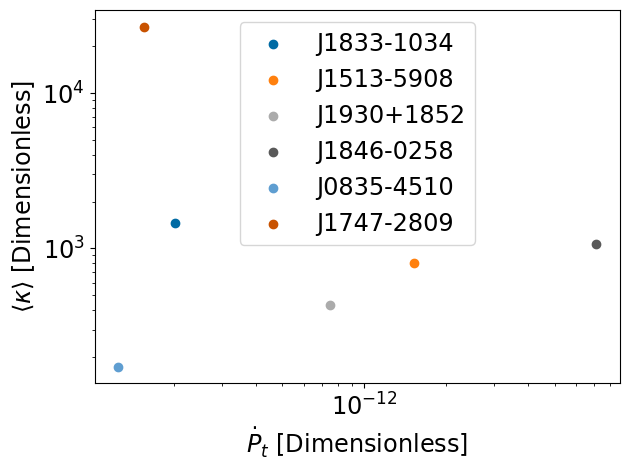

In [37]:
for i in np.arange(len(psrs)):
    plt.scatter(pdots[i],kappas[i],label=psrs[i])

print(pearsonr(pdots,kappas))

plt.legend()
plt.xlabel(r'$\dot{P}_t$ [Dimensionless]')
plt.ylabel(r'$\langle\kappa\rangle$ [Dimensionless]')
plt.loglog()
plt.tight_layout()
plt.savefig('pdot.png',dpi=300)

PearsonRResult(statistic=-0.40131320987817287, pvalue=0.4303463913979411)


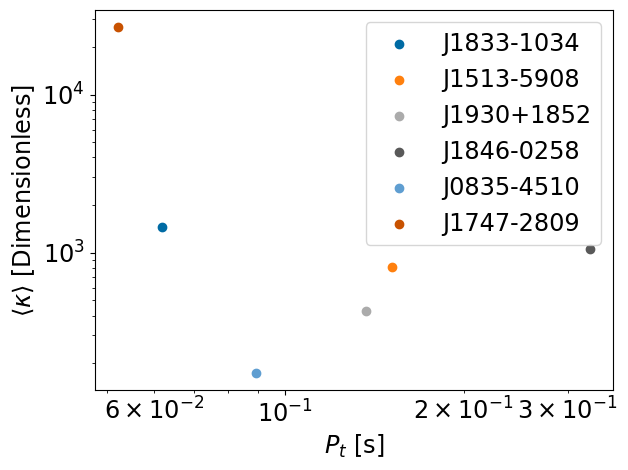

In [38]:
for i in np.arange(len(psrs)):
    plt.scatter(pnows[i],kappas[i],label=psrs[i])
    
print(pearsonr(pnows,kappas))

plt.legend()
plt.xlabel(r'$P_t$ [s]')
plt.ylabel(r'$\langle\kappa\rangle$ [Dimensionless]')
plt.loglog()
plt.tight_layout()
plt.savefig('pnow.png',dpi=300)

PearsonRResult(statistic=0.08888158479426861, pvalue=0.8670287022294584)


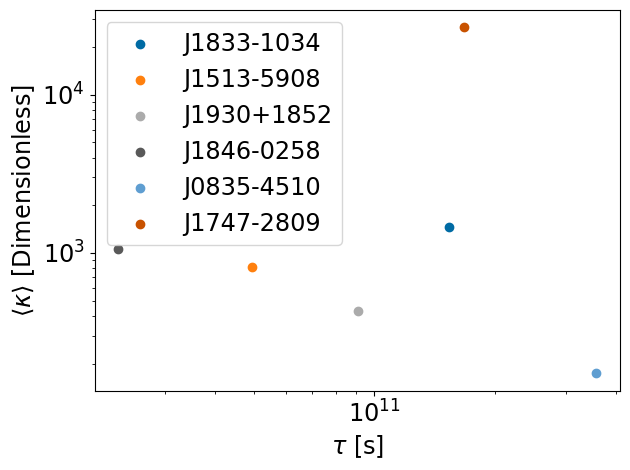

In [39]:
for i in np.arange(len(psrs)):
    plt.scatter(pnows[i]/(2*pdots[i]),kappas[i],label=psrs[i])

print(pearsonr(np.asarray(pnows)/(2*np.asarray(pdots)),kappas))

plt.legend()
plt.xlabel(r'$\tau$ [s]')
plt.ylabel(r'$\langle\kappa\rangle$ [Dimensionless]')
plt.loglog()
plt.tight_layout()
plt.savefig('tau.png',dpi=300)

PearsonRResult(statistic=-0.23431050427098124, pvalue=0.6549662324072181)


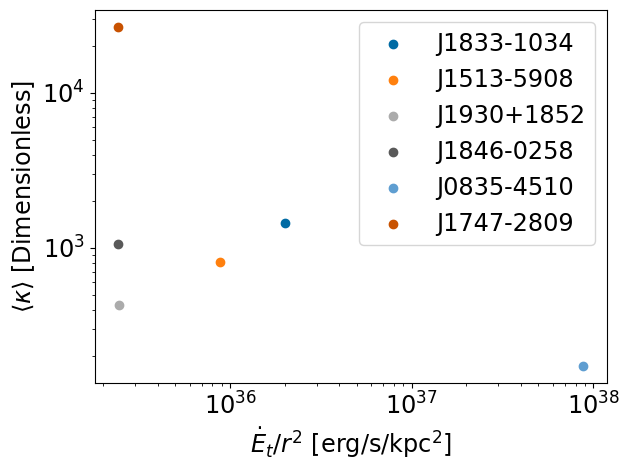

In [40]:
dists=[4.1,4.4,7.0,5.8,0.28,13.3]*u.kpc
for i in np.arange(len(psrs)):
    plt.scatter(edots[i]/dists[i]**2,kappas[i],linestyle='None',label=psrs[i])
    
print(pearsonr(np.asarray(edots)/(np.asarray(dists)**2),kappas))

plt.xlabel(r'$\dot{E}_t/r^2\ \mathrm{[erg/s/kpc^2]}$')
plt.ylabel(r'$\langle\kappa\rangle$ [Dimensionless]')
plt.legend()
plt.loglog()
plt.tight_layout()
plt.savefig('edotoverrsquared.png')

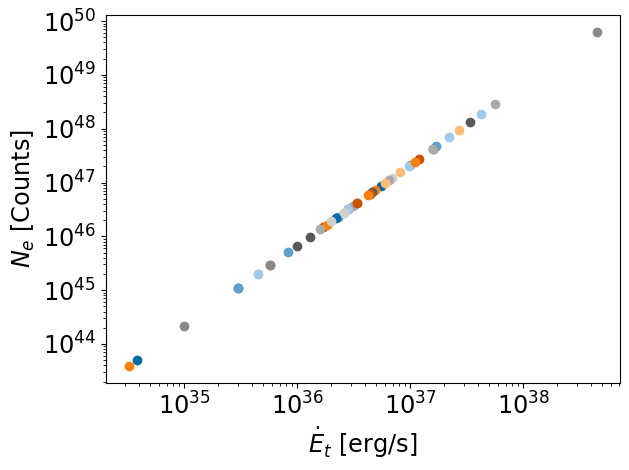

In [41]:
def calc_ngj2(edot_pwn,age_pwn,psr_age=10**3*u.yr,alpha=2):
    
    
    t=np.linspace(0*u.s,age_pwn.to(u.s),100)
    edot_pwnt=edot_pwn*(1+t/psr_age)**alpha
    edot_pwnt=edot_pwnt.to(u.erg/u.s)
    integrand=1*(6*c.c.cgs*edot_pwnt)**0.5/c.e.gauss
    y=simps(integrand,t)
    return y

for i in range(len(df)):
    njs=calc_ngj2(edot[i],10**3*u.yr)
    kappa=0.8e-34*edot[i]**1
    
    plt.scatter(edot[i],njs*2*kappa,label=atnf_names[i])
    
plt.xlabel(r'$\dot{E}_t$ [erg/s]')
plt.ylabel(r'$N_e$ [Counts]')
#plt.legend()
plt.loglog()
plt.tight_layout()